## Interpolate LFM observation site bias correction values across spatiotemporal domain
Last updated: Kevin Varga, 12/27/2024

**Inputs:**
* WRF land mask and elevation netcdfs
* Dataframe summarizing MBE change at each site/quantile
* Dataframe of chamise LFM observation site locations/elevations
* Dataframe of observed, predicted, and corrected at each LFM observation site

**Outputs:**
* Netcdf of interpolated chamise bias corrections throughout spatiotemporal domain

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import RBFInterpolator

In [3]:
# Path for bias corrected model outputs
bc_path = '/home/sbarc/students/varga/nasa/ch1/data/bias_correction/chamise/'
# Path for LFM observations
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/'
# Path for WRF variables
wrf_vars_path = '/home/sbarc/students/varga/nasa/ch1/data/wrf/vars/'
# Path to save gridded bias correction output
grid_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/'

### Create elevation scaler for 3D interpolation

In [4]:
# Open land mask and elevation WRF vars and clean up
land_mask = xr.open_dataarray(wrf_vars_path + 'land_mask.nc')
elevation = xr.open_dataarray(wrf_vars_path + 'elevation.nc')

# Extract WRF lat/lon values
wrf_lats = land_mask['XLAT'].values[:,0]
wrf_lons = land_mask['XLONG'].values[0,:]

# Calculate mean degree difference between lat and lon grid points to use as an altitude scaler
# Note: latitude and longitude grid is at 1km resolution
lat_dist_mean = np.array([wrf_lats[i+1] - wrf_lats[i] for i in range(len(wrf_lats)-1)]).mean()
lon_dist_mean = np.array([wrf_lons[i+1] - wrf_lons[i] for i in range(len(wrf_lons)-1)]).mean()
grid_elev_scaler = (lat_dist_mean + lon_dist_mean) / 2

# Assign lat/lon coordinates as spatial dimensions and clean up
land_mask['south_north'] = wrf_lats
land_mask['west_east'] = wrf_lons
land_mask = land_mask.rename({'south_north':'latitude', 'west_east':'longitude'})
ex_coords = ['XLAT','XLONG','XTIME']
land_mask = land_mask.drop(ex_coords)

# Assign lat/lon coordinates as spatial dimensions and clean up
elevation['south_north'] = wrf_lats
elevation['west_east'] = wrf_lons
elevation = elevation.rename({'south_north':'latitude', 'west_east':'longitude'})
elevation = elevation.drop(['XLAT','XLONG'])

# Create mask for land
land_mask = (land_mask >=1)

# Crop elevation to land mask
elevation = elevation.where(land_mask, drop=True)
# Convert meters to km and scale to lat/lon grid
elevation = (elevation / 1000) * grid_elev_scaler

# Re-save WRF lat/lon values of masked domain
wrf_lats = elevation['latitude'].values
wrf_lons = elevation['longitude'].values

### Determine the number of quantiles that reduces MBE the greatest and set up model dataframe

In [5]:
# Read in summary stats of MBE change at LFM obs sites for different quantile mapping values
stat_sum_df = pd.read_csv(bc_path + '/q_stats_summary.csv', index_col = 'site')
# Select the number of quantiles with the greatest mean reduction in MBE
best_quantile = stat_sum_df.loc['mean', :].astype(float).idxmin()
print(f'{best_quantile} quantiles has the greatest reduction of MBE across all observation sites')

30 quantiles has the greatest reduction of MBE across all observation sites


In [6]:
# Read in model output using the chosen quantile
model_df = pd.read_csv(bc_path + best_quantile + '_model_output.csv', 
                       index_col=[0,1], parse_dates=True, infer_datetime_format=True)
# Save date range
dates = pd.unique(model_df.index.get_level_values(1))
# Calculate the bias correction for every site for every time step
model_df.loc[:, 'correction'] = model_df['corrected'] - model_df['predicted']

# Read in LFM observation sites
obs_df = pd.read_csv(obs_path + 'lfm_crop_site_loc.csv', index_col='site')
# Convert LFM site elevation from feet to meters and scale to lat/lon grid
obs_df.loc[:, 'elevation'] = obs_df['elevation'] * 0.0003048 * grid_elev_scaler

# Map lat/lon of LFM observation sites to model dataframe
lats_map = dict(zip(obs_df.index, obs_df['latitude']))
lons_map = dict(zip(obs_df.index, obs_df['longitude']))
model_df.loc[:, 'latitude'] = model_df.index.get_level_values(0).map(lats_map)
model_df.loc[:, 'longitude'] = model_df.index.get_level_values(0).map(lons_map)

### Interpolate bias correction with RBF Interpolator

In [7]:
# Create array of locations with elevation
observed_locations = np.array(list(zip(obs_df['longitude'], obs_df['latitude'], obs_df['elevation'])))
# Create array of corrections at each site for each date
observed_corrections = np.array([model_df.xs(dates[i], level=1)['correction'].to_numpy() for i in range(len(dates))])

# Create empty array to store interpolated results
interpolated_results = np.empty((len(dates), len(wrf_lats), len(wrf_lons)))

# Create grid and list of lat/lon/elevation points
X, Y = np.meshgrid(wrf_lons, wrf_lats)
flat = np.column_stack([X.flatten(), Y.flatten(), elevation.to_numpy().flatten()])

In [8]:
%%time
# Run RBF Interpolator for every time step with default thin-plate spline kernel 
for t in range(len(dates)):
    # Compute the range of observed corrections
    min_correction = np.min(observed_corrections[t])
    max_correction = np.max(observed_corrections[t])
    # Use 0.01 for smoothing to negate exact fit requirement
    yflat = RBFInterpolator(observed_locations, observed_corrections[t], smoothing=0.01)(flat)
    # Convert interpolated results back into grid and clip to min and max for that time step
    interpolated_results[t] = np.clip(yflat.reshape(X.shape), min_correction, max_correction)

CPU times: user 6min 2s, sys: 18min 53s, total: 24min 55s
Wall time: 1min 47s


In [9]:
# Create data array for storing interpolated bias corrections
correction_da = xr.DataArray(data = interpolated_results,
    coords={
        'time': dates,
        'latitude': wrf_lats,
        'longitude': wrf_lons
    }
)

In [10]:
correction_da.to_netcdf(grid_path + 'bias_correction.nc')

### Plot interpolated bias corrections with observation locations
#### Used to visualize interpolation techniques and smoothing factors

In [11]:
import cartopy.crs as ccrs

In [12]:
correction_da = xr.open_dataarray(grid_path + 'bias_correction.nc')
# Read in LFM observation sites
obs_df = pd.read_csv(obs_path + 'lfm_crop_site_loc.csv', index_col='site')

In [13]:
def da_extreme_values(da):
    """Generate max and min values of individual time steps for an xarray DataArray."""
    # Calculate max and min across the spatial domain for every time step
    import datetime as dt
    ts_max = da.max(dim=['latitude', 'longitude'])
    ts_min = da.min(dim=['latitude', 'longitude'])

    # Sort the indices of the data array in descending order
    max_sorted_indices = ts_max.argsort()[::-1]
    # Select the first 20 indices from the sorted indices
    max_20_indices = max_sorted_indices[:20].values
    max_20_times = pd.to_datetime(ts_max['time'].isel(time=max_20_indices).values)

    # Sort the indices of the data array in ascending order
    min_sorted_indices = ts_min.argsort()
    # Select the first 20 indices from the sorted indices
    min_20_indices = min_sorted_indices[:20].values
    min_20_times = pd.to_datetime(ts_max['time'].isel(time=min_20_indices).values)

    # Get the top 20 max and min values along with their corresponding time steps
    max_20_values = ts_max.isel(time=max_20_indices).values
    min_20_values = ts_min.isel(time=min_20_indices).values

    # Return the results as a dictionary
    results = {
        "max_20_indices": max_20_indices,
        "max_20_times": max_20_times,
        "max_20_values": max_20_values,
        "min_20_indices": min_20_indices,
        "min_20_times": min_20_times,
        "min_20_values": min_20_values
    }
    return results

In [17]:
# Identify time steps when bias correction has greatest positive and negative corrections
ex_values = da_extreme_values(correction_da)
print(ex_values['max_20_times'])
print(ex_values['min_20_times'])

DatetimeIndex(['2005-04-01', '1997-03-15', '2000-04-01', '1995-04-01',
               '1992-05-01', '1998-03-01', '1993-03-15', '1990-04-01',
               '1991-05-01', '1998-03-15', '1997-03-01', '1993-04-01',
               '1998-04-15', '2017-03-15', '2010-04-01', '2019-04-15',
               '2011-03-15', '2005-03-15', '2019-04-01', '1995-03-15'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2011-04-15', '1998-04-15', '1991-05-15', '1995-03-01',
               '2011-04-01', '1995-02-15', '2003-03-15', '1995-03-15',
               '1992-03-15', '2010-04-01', '2010-03-15', '2005-03-15',
               '1996-04-01', '2018-04-15', '1989-03-15', '2006-04-01',
               '2006-04-15', '2011-03-15', '1988-03-01', '2008-04-01'],
              dtype='datetime64[ns]', freq=None)


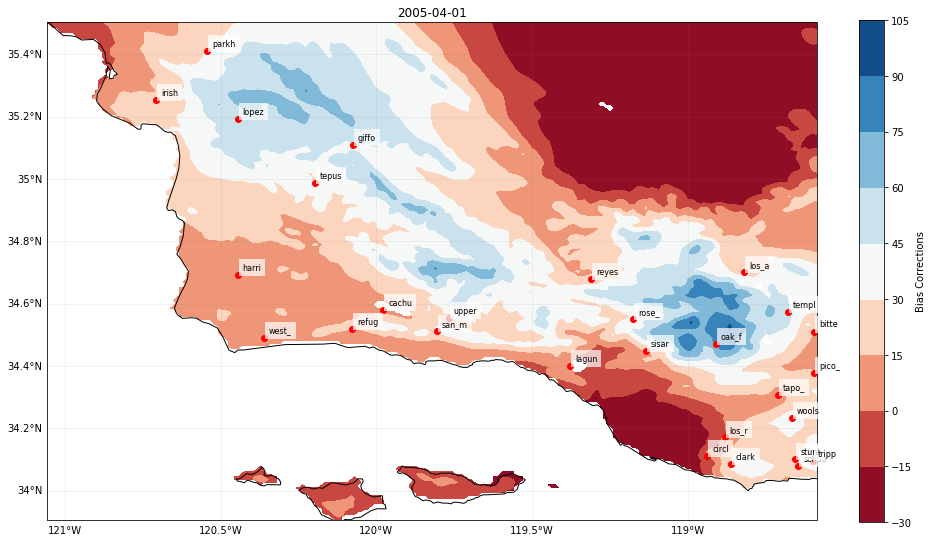

In [18]:
# Select time stamp
t='2005-04-01'

# Interpolated results for a single time step
interpolated_timestamp = correction_da.sel(time=t).values

# Create a map visualization
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot interpolated results
contour = plt.contourf(wrf_lons, wrf_lats, interpolated_timestamp, cmap='RdBu')

# Plot observed locations
plt.scatter(obs_df['longitude'].values, obs_df['latitude'].values, c='red', marker='o', label='Observed Locations')

# Add site labels
for idx, row in obs_df.iterrows():
    site_label = str(idx)[:5]  # Get first 3 characters of the site name
    plt.annotate(site_label, 
                (row['longitude'], row['latitude']),
                xytext=(5, 5),  # 5 points offset
                textcoords='offset points',
                fontsize=8,
                color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Customize the plot
plt.title(t)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend()

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.1)
gl.top_labels = False  # Remove top longitude labels
gl.right_labels = False  # Remove right latitude labels

# Add a colorbar
cbar = plt.colorbar(contour, orientation='vertical', fraction=0.03)
cbar.set_label('Bias Corrections')

# Show the plot
plt.show()